<a href="https://colab.research.google.com/github/rahiakela/kaggle-competition-projects/blob/master/denoising-dirty-documents/02_denoising_images_using_random_forest_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Denoising images using Autoencoders

**Reference**

https://pyimagesearch.com/2021/10/20/using-machine-learning-to-denoise-images-for-better-ocr-accuracy/

https://github.com/PyImageSearch/imutils/blob/master/imutils/paths.py

##Setup

In [ ]:
!sudo apt-get install poppler-utils

In [ ]:
!pip install pdf2image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import progressbar
import random
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, Input
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import cv2 
from pdf2image import convert_from_path
from io import BytesIO
from PIL import Image

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [3]:
# change the working directory
%cd .

/content


In [4]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/competitions/denoising-dirty-documents
kaggle competitions download -c denoising-dirty-documents

unzip -qq denoising-dirty-documents.zip
rm -rf denoising-dirty-documents.zip

100% 35.7M/35.7M [00:00<00:00, 95.6MB/s]
100% 35.7M/35.7M [00:00<00:00, 85.7MB/s]


In [ ]:
# unzip files
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
  zip_ref.extractall(".")

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
  zip_ref.extractall(".")  
    
with zipfile.ZipFile('train_cleaned.zip', 'r') as zip_ref:
  zip_ref.extractall(".")  
    
with zipfile.ZipFile('sampleSubmission.csv.zip', 'r') as zip_ref:
  zip_ref.extractall(".")

In [ ]:
# initialize the base path to the input documents dataset
BASE_PATH = "."
# define the path to the training directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "train"])
CLEANED_PATH = os.path.sep.join([BASE_PATH, "train_cleaned"])

# define the path to our output features CSV file
FEATURES_PATH = "features.csv"
SAMPLE_PROB = 0.02
# define the path to our document denoiser model
MODEL_PATH = "denoiser.pickle"

##Blur and Threshold Helper Function

In [ ]:
def blur_and_threshold(image, eps=1e-7):
    # apply a median blur to the image and then subtract the blurred
	  # image from the original image to approximate the foreground
    blur = cv2.medianBlur(image, 5)
    foreground = image.astype("float") - blur

    # threshold the foreground image by setting any pixels with a value greater than zero to zero
    foreground[foreground > 0] = 0

    # apply min/max scaling to bring the pixel intensities to the range [0, 1]
    min_val = np.min(foreground)
    max_val = np.max(foreground)
    foreground = (foreground - min_val) / (max_val - min_val + eps)

    # return the foreground-approximated image
    return foreground

##Feature Extraction

In [ ]:
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")


def list_images(basePath, contains=None):
  # return the set of files that are valid
  return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
  # loop over the directory structure
  for (rootDir, dirNames, filenames) in os.walk(basePath):
      # loop over the filenames in the current directory
      for filename in filenames:
          # if the contains string is not none and the filename does not contain
          # the supplied string, then ignore the file
          if contains is not None and filename.find(contains) == -1:
              continue

          # determine the file extension of the current file
          ext = filename[filename.rfind("."):].lower()

          # check to see if the file is an image and should be processed
          if validExts is None or ext.endswith(validExts):
              # construct the path to the image and yield it
              imagePath = os.path.join(rootDir, filename)
              yield imagePath

In [ ]:
# grab the paths to our training images
train_paths = sorted(list(list_images(TRAIN_PATH)))
cleaned_paths = sorted(list(list_images(CLEANED_PATH)))
# initialize the progress bar
widgets = ["Creating Features: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(train_paths), widgets=widgets).start()

# zip our training paths together, then open the output CSV file for writing
image_paths = zip(train_paths, cleaned_paths)
csv = open(FEATURES_PATH, "w")

# loop over the training images together
for (i, (train_path, cleaned_path)) in enumerate(image_paths):
  # load the noisy and corresponding gold-standard cleaned images and convert them to grayscale
  train_image = cv2.imread(train_path)
  clean_image = cv2.imread(cleaned_path)
  train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
  clean_image = cv2.cvtColor(clean_image, cv2.COLOR_BGR2GRAY)

  # apply 2x2 padding to both images, replicating the pixels along the border/boundary
  train_image = cv2.copyMakeBorder(train_image, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
  clean_image = cv2.copyMakeBorder(clean_image, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

  # blur and threshold the noisy image
  train_image = blur_and_threshold(train_image)

  # scale the pixel intensities in the cleaned image from the range [0, 255] to [0, 1] (the noisy image is already in the range [0, 1])
  clean_image = clean_image.astype("float") / 255.0

  # slide a 5x5 window across the images
  for y in range(0, train_image.shape[0]):
    for x in range(0, train_image.shape[1]):
      # extract the window ROIs for both the train image and clean image, then grab the spatial dimensions of the ROI
      train_roi = train_image[y: y + 5, x: x + 5]
      clean_roi = clean_image[y: y + 5, x: x + 5]
      (rh, rw) = train_roi.shape[:2]

      # if the ROI is not 5x5, throw it out
      if rw != 5 or rh != 5:
        continue
      
      # our features will be the flattened 5x5=25 raw pixels
      features = train_roi.flatten()
      target = clean_roi[2, 2]

      # let's only write rows to disk with probability N, thereby reducing the total number of rows in the file
      if random.random() <= SAMPLE_PROB:
        # write the target and features to our CSV file
        features = [str(x) for x in features]
        row = [str(target)] + features
        row = ",".join(row)
        csv.write("{}\n".format(row))

  # update the progress bar
  pbar.update(i)

# close the CSV file
pbar.finish()
csv.close()

Creating Features: 100% |######################################| Time:  0:01:31


In [ ]:
!ls -l *.csv

-rw-r--r-- 1 root root 274213440 Apr 28 10:37 features.csv
-rw-r--r-- 1 root root 186373233 Apr 28 10:20 sampleSubmission.csv


In [ ]:
df = pd.read_csv("features.csv")
df.head()

,1.0,0.9999999995555556,0.9911111106706173,0.9911111106706173.1,0.9999999995555556.1,0.9999999995555556.2,0.9999999995555556.3,0.9911111106706173.2,0.9911111106706173.3,0.9999999995555556.4,...,0.9999999995555556.9,0.9777777773432099,0.9733333329007408,0.9999999995555556.10,0.9999999995555556.11,0.9999999995555556.12,0.9822222217856791,0.9733333329007408.1,0.9955555551130865,0.9999999995555556.13
0,1.0,0.991111,1.000000,1.000000,1.000000,0.986667,0.991111,1.0,1.000000,1.000000,...,0.973333,1.000000,1.000000,1.000000,0.995556,0.973333,0.995556,1.0,1.000000,1.0
1,1.0,1.000000,1.000000,1.000000,0.986667,1.000000,1.000000,1.0,1.000000,0.986667,...,1.000000,1.000000,1.000000,0.995556,1.000000,0.995556,1.000000,1.0,1.000000,1.0
2,1.0,1.000000,1.000000,0.986667,0.995556,1.000000,1.000000,1.0,0.986667,0.995556,...,1.000000,1.000000,0.995556,0.991111,0.977778,0.991111,0.991111,1.0,1.000000,1.0
3,1.0,1.000000,1.000000,0.995556,1.000000,1.000000,1.000000,1.0,0.995556,1.000000,...,0.991111,0.995556,1.000000,1.000000,1.000000,0.991111,1.000000,1.0,0.995556,1.0
4,1.0,1.000000,0.991111,1.000000,0.977778,1.000000,1.000000,1.0,1.000000,0.977778,...,0.982222,0.973333,0.995556,0.982222,1.000000,0.991111,0.973333,1.0,0.995556,1.0


##Training RFR model

In [ ]:
print("[INFO] loading dataset...")
features = []
targets = []

for row in open(FEATURES_PATH):
  # parse the row and extract 
  # (1) the target pixel value to predict along with 
  # (2) the 5x5=25 pixels which will serve as our feature vector
  row = row.strip().split(",")
  row = [float(x) for x in row]
  target = row[0]
  pixels = row[1:]

  features.append(pixels)
  targets.append(target)

# convert the features and targets to NumPy arrays
features = np.array(features, dtype="float")
target = np.array(targets, dtype="float")

# construct our training and testing split
(x_train, x_test, y_train, y_test) = train_test_split(features, target, test_size=0.25, random_state=42)

# train a random forest regressor on our data
print("[INFO] training model...")
model = RandomForestRegressor(n_estimators=10)
model.fit(x_train, y_train)

# compute the root mean squared error on the testing set
print("[INFO] evaluating model...")
preds = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"[INFO] rmse: {str(rmse)}")

# serialize our random forest regressor to disk
f = open(MODEL_PATH, "wb")
f.write(pickle.dumps(model))
f.close()

[INFO] loading dataset...
[INFO] training model...
[INFO] evaluating model...
[INFO] rmse: 0.050490518533545296


In [ ]:
!ls -l *.pickle

-rw-r--r-- 1 root root 80278974 Apr 28 11:17 denoiser.pickle


##Document Denoiser

##Prediction

In [ ]:
y_pred = conv_autoencoder.predict(x_test, batch_size=16)

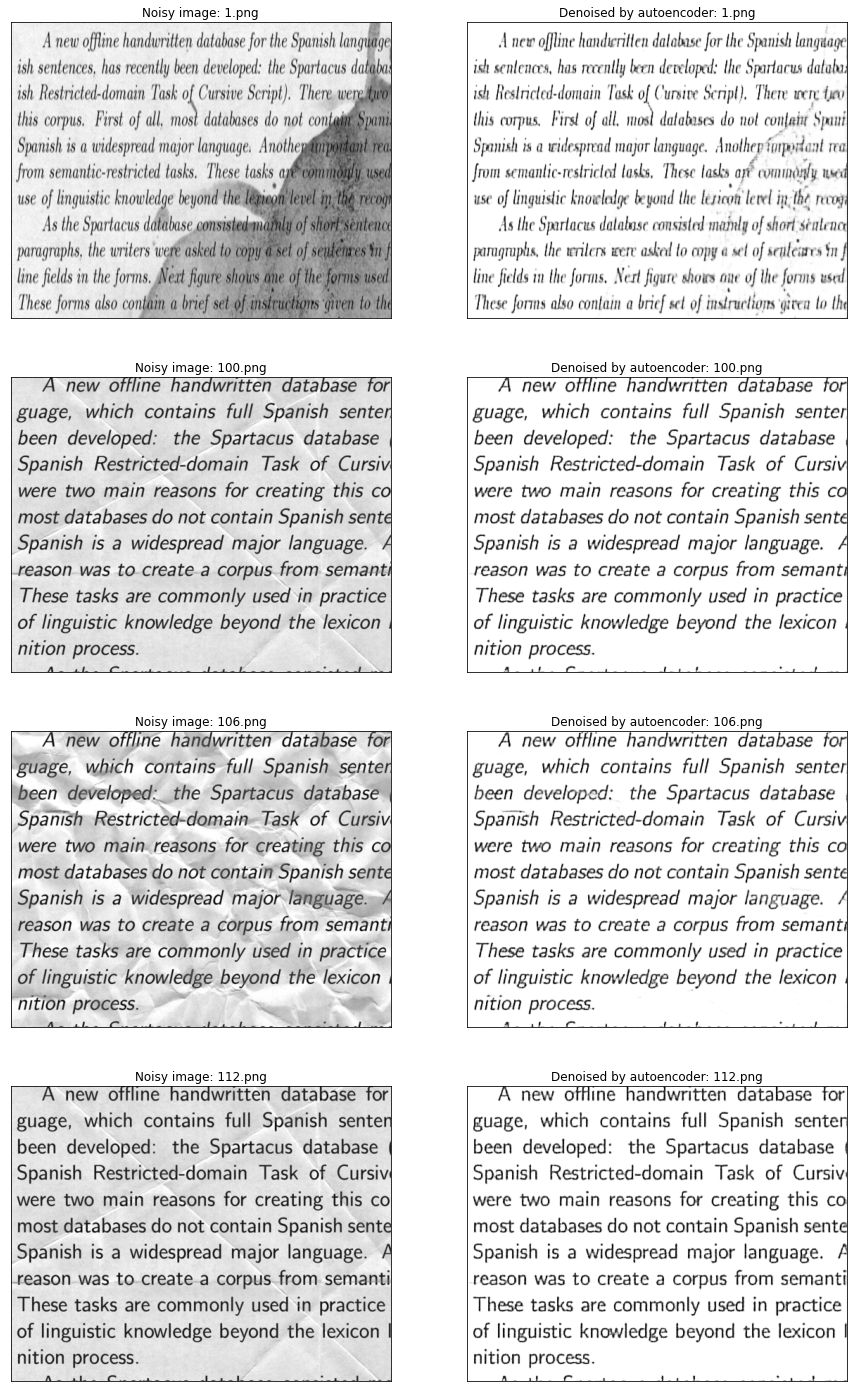

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[i][:,:,0], cmap='gray')
  plt.title('Noisy image: {}'.format(test_img[i]))
  
  plt.subplot(4,2,i+2)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(y_pred[i][:,:,0], cmap='gray')
  plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
x_test[0].shape

(420, 540, 1)

##Denoising image

In [ ]:
def img_display(im_data):
    dpi = 80
    #im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
pdf_file = 'document-page40.pdf'
pages = convert_from_path(pdf_file)
for page in pages:
  page.save("doc.jpg", "JPEG")

In [ ]:
image = cv2.imread("doc.jpg")
# Binarization
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
gray_image.shape

(2200, 1700)

In [ ]:
img_display(gray_image)

In [ ]:
#img_display(x_test[0])
plt.imshow(x_test[0][:,:,0], cmap='gray')

NameError: ignored

In [ ]:
resized_img = cv2.resize(x_test[0], (2200, 1700), interpolation=cv2.INTER_AREA)

In [ ]:
resized_img = resized_img[..., np.newaxis]
resized_img.shape

(1700, 2200, 1)

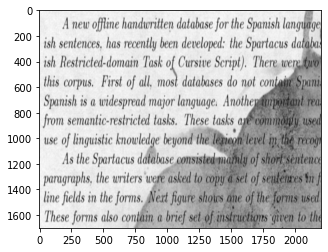

In [ ]:
plt.imshow(resized_img[:,:,0], cmap='gray')

In [ ]:
resized_img = cv2.resize(gray_image, (420, 540), interpolation=cv2.INTER_AREA)

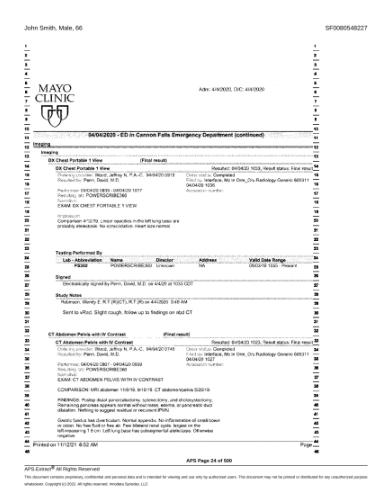

In [ ]:
img_display(resized_img)

In [ ]:
resized_img = resized_img[..., np.newaxis]
resized_img.shape

(540, 420, 1)

In [ ]:
y_pred = conv_autoencoder.predict(resized_img)

In [ ]:
y_pred[0]

array([[[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [ ]:
cv2.imwrite("out.png", y_pred)

False

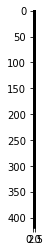

In [ ]:
#image = cv2.imread("doc.jpg")

# img_display(y_pred)
plt.imshow(y_pred[0][:,:,0], cmap='gray')